In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import pytorch_lightning as pl

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                     Energy_Consumption
Start_DateTime                         
2018-01-01 17:49:00               6.504
2018-01-01 17:49:00               6.504
2018-01-02 08:52:00               2.481
2018-01-02 08:52:00               2.481
2018-01-02 21:11:00              15.046
...                                 ...
2019-08-06 08:48:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 08:56:00               0.000
2019-08-07 10:17:00              11.060
2019-08-07 10:17:00              11.060

[968 rows x 1 columns]


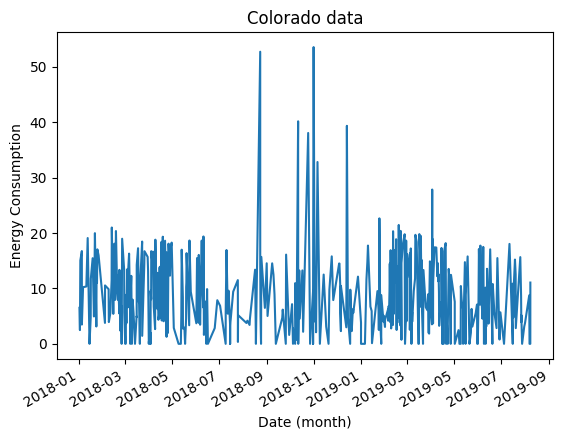

In [4]:
df = pd.read_csv('ColoradoData_Boulder.csv')
df.index = df['Start_DateTime']
df = df[['Start_DateTime', 'Energy_Consumption']].sort_index()
df.dropna(inplace=True)
df['Start_DateTime'] = pd.to_datetime(df['Start_DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('Start_DateTime', inplace=True)
print(df)

plt.title("Colorado data")
plt.ylabel("Energy Consumption")
plt.xlabel("Date (month)")
plt.plot(df['Energy_Consumption'])
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()


In [5]:
train_size = int(0.6 * len(df))
validation_size = int(0.2 * len(df))
test_size = int(0.2 * len(df))

all_data = df['Energy_Consumption'].values.astype(float)

train_set = all_data[:train_size]
validation_set = all_data[train_size:train_size + validation_size]
test_set = all_data[train_size + validation_size]

print(train_size, validation_size, test_size)
print(all_data[:30])

580 193 193
[ 6.504  6.504  2.481  2.481 15.046 15.046 16.744 16.744  3.476  3.476
 10.224 10.224 10.348 10.348 19.095 19.095  0.     0.     4.71   4.71
 11.752 11.752 15.456 15.456  4.94   4.94   8.738  8.738 19.976 19.976]


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_set.reshape(-1, 1))
validation_data_normalized = scaler.fit_transform(validation_set.reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_set.reshape(-1, 1))

train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
validation_data_normalized = torch.FloatTensor(validation_data_normalized).view(-1)
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)

print(train_data_normalized[:5])
print(validation_data_normalized[:5])
print(test_data_normalized[:5])

tensor([-0.7572, -0.7572, -0.9074, -0.9074, -0.4382])
tensor([-0.5105, -0.5105, -0.6737, -0.6737, -0.3181])
tensor([-1.])


In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, train_window):
        self.data = data
        self.sequences = self.create_inout_sequences(data, train_window)

    def create_inout_sequences(self, input_data, tw):
        inout_seq = []
        L = len(input_data)
        for i in range(L-tw):
            train_seq = input_data[i:i+tw]
            train_label = input_data[i+tw:i+tw+1]
            inout_seq.append((train_seq, train_label))
        return inout_seq

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

In [8]:
train_window = 12
validation_window = 12

train_dataset = TimeSeriesDataset(train_data_normalized, train_window)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

validation_dataset = TimeSeriesDataset(validation_data_normalized, validation_window)
validation_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))
        self.name = "LSTM"

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

## Training + Validation

In [10]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
min_valid_loss = np.inf

for e in range(epochs):
  train_loss = 0.0
  model.train()
  for data, labels in train_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
    for seq, label in zip(data, labels):
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
      y_pred = model(seq)
      loss = loss_function(y_pred, label)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

  valid_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data, labels in validation_loader:
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
      
      for seq, label in zip(data, labels):
        y_pred = model(seq)
        loss = loss_function(y_pred, label)
        valid_loss = loss.item() * data.size(0)
    
    print(f'Epoch {e+1}  Training Loss: {train_loss / len(train_loader):10.8f} \t\t Validation Loss: {valid_loss / len(validation_loader):10.8f}')
    if min_valid_loss > valid_loss:
      print(f'\t --> Val loss decreased, saving model \t {min_valid_loss:.6f}-->{valid_loss:.6f}')
      min_valid_loss = valid_loss
      torch.save(model.state_dict(), f'./Models/{model.name}.pth')

Epoch 1  Training Loss: 55.10658056 		 Validation Loss: 19.06237638
	 --> Val loss decreased, saving model 	 inf-->19.062376
Epoch 2  Training Loss: 38.49543536 		 Validation Loss: 20.31405666
Epoch 3  Training Loss: 30.29360154 		 Validation Loss: 19.74243653
Epoch 4  Training Loss: 28.53273824 		 Validation Loss: 17.98927850
	 --> Val loss decreased, saving model 	 19.062376-->17.989279
Epoch 5  Training Loss: 27.92833896 		 Validation Loss: 20.83093760


## Testing model (in progress)

In [ ]:
model = torch.load(f'./Models/{model.name}.pth', weights_only=False)
model.eval()
with torch.no_grad():
  for data, labels in validation_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
    
    for seq, label in zip(data, labels):
      y_pred = model(seq)
      loss = loss_function(y_pred, label)
      valid_loss = loss.item() * data.size(0)

## Old code

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 12
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
print(train_inout_seq[:5])

In [79]:
epochs = 150

for i in range(epochs):
    model.train(True)
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()
        
    if i%25 == 0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

print(f'epoch: {i:3} loss: {loss.item():10.10f}')

epoch:   0 loss: 0.00530617


KeyboardInterrupt: 

In [73]:
fut_pred = 29

test_inputs = train_data_normalized[-train_window:].tolist()

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
pred_index = df.index[len(df)-fut_pred:]

print(test_inputs)
print(test_inputs[fut_pred:])
print(predictions)


[-0.8511341214179993, -0.8511341214179993, -0.8095771670341492, -0.8095771670341492, -0.8861569762229919, -0.8861569762229919, -0.8391113877296448, -0.8391113877296448, -0.7651824951171875, -0.7651824951171875, -0.8443386554718018, -0.8443386554718018, -0.8288962841033936, -0.6181994676589966, -0.4825688898563385, -0.4582783579826355, -0.5697152018547058, -0.7780053615570068, -0.6862243413925171, -0.5965283513069153, -0.48133671283721924, -0.44673436880111694, -0.72014319896698, -0.8539028167724609, -0.9141615629196167, -0.9506299495697021, -0.9963932037353516, -1.0073273181915283, -1.0088142156600952, -0.9118518829345703, -0.8962496519088745, -0.8291119337081909, -0.8422355055809021, -0.678454577922821, -0.6655446290969849, -0.11314907670021057, -0.04754355549812317, -0.7402311563491821, -0.7930171489715576, -0.41457346081733704, -0.40052393078804016]
[-0.9118518829345703, -0.8962496519088745, -0.8291119337081909, -0.8422355055809021, -0.678454577922821, -0.6655446290969849, -0.113149

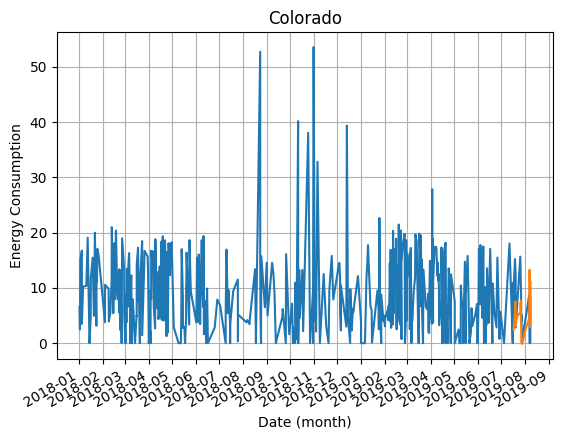

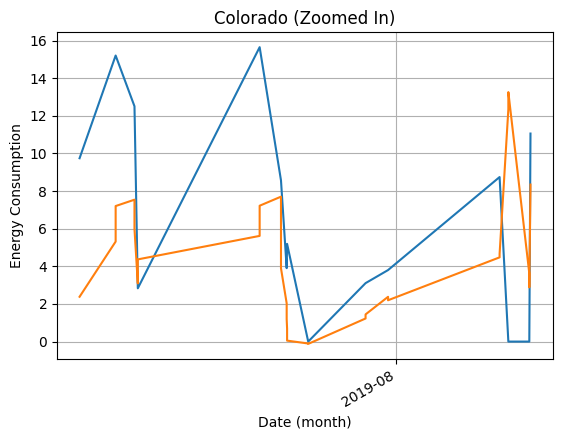

In [77]:
plt.title("Colorado")
plt.xlabel("Date (month)")
plt.ylabel("Energy Consumption")
plt.grid(True)
plt.plot(df.index, df['Energy_Consumption'])
plt.plot(pred_index, predictions)
plt.plot()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date labels
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()

#Zoomed in
plt.title("Colorado (Zoomed In)")
plt.xlabel("Date (month)")
plt.ylabel("Energy Consumption")
plt.grid(True)
plt.plot(df.index[-fut_pred:], df['Energy_Consumption'][-fut_pred:])
plt.plot(pred_index, predictions)
plt.plot()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to monthly intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date labels
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.show()